# PROJET : 
# RECONNAISSANCE VOCALE
# SYSTEME DE TRADUCTION ADAPTE AUX LUNETTES CONNECTEES  
  
    
      
***

   
      
   
## Partie I : Exploration des données et Dataviz   
   
   


   
### 1. Pré-traitement des données   
   
   

   
#### Importation des modules nécessaires   
   

In [16]:
# -*- coding: utf-8 -*-
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np

import nltk
nltk.download('punkt')
from nltk.tokenize import PunktSentenceTokenizer 
from nltk.tokenize import word_tokenize
from nltk import word_tokenize, pos_tag
from nltk.tag import StanfordPOSTagger
import re
import swifter

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mouni\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


   
#### Prétraitement et vérification du fichier de données de base   
   

In [2]:
#Importation du fichier de données 'data' à partir des données transformées en csv
data = pd.read_csv('small_vocab_fr-eng.csv', sep= ';')

# Prévisualisation des données pour vérifier le bon chargement du fichier et l'encodage
display(data.head())

# Vérification des données du tableaux 
# pas de données nulles -> chaque phrase a une correspondance en français et en anglais
# le nombre de lignes (de phrases) est très important (137 860) 
print(data.info())

# Vérification des éventuels doublons
p=data.duplicated().sum()
print('le nombre de doublons est de:', p)

# Suppression des doublons 
data.drop_duplicates(inplace=True)

,Français,English
0,new jersey est parfois calme pendant l' automn...,"new jersey is sometimes quiet during autumn , ..."
1,les états-unis est généralement froid en juill...,the united states is usually chilly during jul...
2,"california est généralement calme en mars , et...","california is usually quiet during march , and..."
3,"les états-unis est parfois légère en juin , et...",the united states is sometimes mild during jun...
4,"votre moins aimé fruit est le raisin , mais mo...","your least liked fruit is the grape , but my l..."


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137860 entries, 0 to 137859
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Français  137860 non-null  object
 1   English   137860 non-null  object
dtypes: object(2)
memory usage: 2.1+ MB
None
le nombre de doublons est de: 8686


   
### 2. Etudes sur le nombre de mots par phrase   
   

Nous allons dans un premier temps, nous intéresser au nombre de mots par phrase en version anglaise d'une part et en version francaise d'autre part.

Pour ce faire, nous allons rajouter au DataFrame deux colonnes fournissant le nombre de mots dans chacune des deux langues ainsi qu'une autre colonne indiquant la différence de mots (nombre de mots français - nombre de mots anglais).

Par la suite, cette différence sera nommée "écart". Elle est positive si la phrase est plus longue en français et négative dans le cas opposé.
   
   

In [5]:
# Création d'une copie de data pour le travail sur le nombre de mots entre la version français et anglaise
nb_words=pd.DataFrame(data, data.index, data.columns)

# Création d'une colonne 'Nb_words_fr' fournissant le nombre de mots part phrase en français
    #création d'une liste qui prend en valeur le nombre de mots pour chaque phrase de la colonne 'Français'
nb_words_fr=[]
for sentence in nb_words['Français']:
    nb_words_fr.append(len(word_tokenize(sentence, language='french')))
    
    # transformation de la liste en array puis compilation dans le dataframe 
nb_words_fr=np.array(nb_words_fr)
nb_words['Nb_words_fr']=nb_words_fr

# Création d'une colonne 'Nb_words_en' fournissant le nombre de mots part phrase en anglais
    #création d'une liste qui prend en valeur le nombre de mots pour chaque phrase de la colonne 'Anglais'
nb_words_en=[]
for sentence in nb_words['English']:
    nb_words_en.append(len(word_tokenize(sentence, language='english')))
    
    # transformation de la liste en array puis compilation dans le dataframe 
nb_words_en=np.array(nb_words_en)
nb_words['Nb_words_en']=nb_words_en

# Création d'une colonne fournissant la différence (nombre de mots en français - nombre de mots en anglais)
nb_words['diff_F-E']=nb_words['Nb_words_fr']-nb_words['Nb_words_en']

#### Prélude statistique

In [6]:
# tableau de description 
nb_words.describe()

,Nb_words_fr,Nb_words_en,diff_F-E
count,129174.000000,129174.00000,129174.000000
mean,14.756491,13.59457,1.161921
std,3.203197,3.01072,1.520051
min,3.000000,4.00000,-4.000000
25%,14.000000,14.00000,0.000000
50%,16.000000,15.00000,1.000000
75%,17.000000,16.00000,2.000000
max,25.000000,17.00000,10.000000


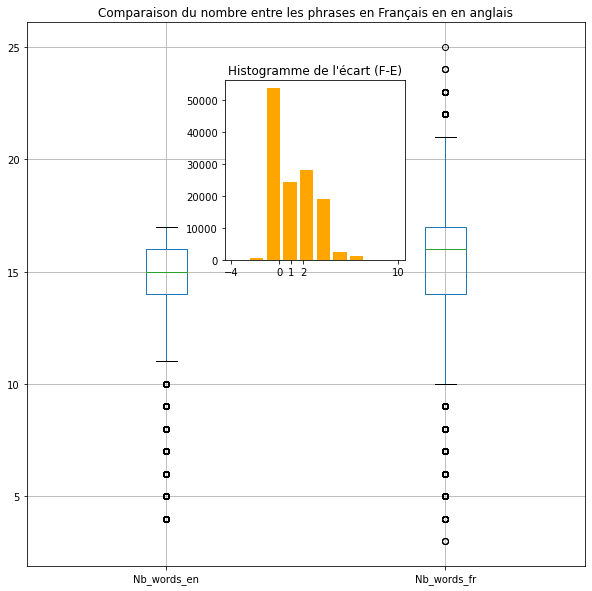

In [7]:
# Première comparaison du nombre de mots

plt.figure(figsize=(10,10))
nb_words.boxplot(column=['Nb_words_en', 'Nb_words_fr'])
plt.title('Comparaison du nombre entre les phrases en Français en en anglais')
plt.axes ([0.4,0.55,0.25,0.25])
plt.hist(nb_words['diff_F-E'], rwidth=0.8, color='orange')
plt.xticks([-4,0,1,2,10])
plt.title("Histogramme de l'écart (F-E)");

La moyenne du nombre de mots par phrase en anglais (13.6) est légèrement inférieure à celle en francais (14.8), les médianes sont également relativement proches.

Plus la phrase est longue, plus l'écart semble se creuser avec un maximum à 25 mots en français et à 17 mots en anglais. L'anglais semble une langue plus "comptacte" sur des longues phrases.

L'histogramme de l'écart montre qu'il y a beaucoup de phrases (+50 000) où l'écart est très légèrement négatif(-1). A part ces valeurs, l'écart toujours positif mais le nombre d'échantillons est plus faible.

Ce qui exprime que la moyenne de l'écart est relativement basse (1.16) voire parfois négative (-4) ou nulle sur les petites phrases (moins de 14 mots).
  
  

### 3. Etude sur le type de phrases  
  
  

L'affichage des plus petits écart permet de réaliser rapidement que ces phrases sont souvent interrogatives. Nous proposons donc de séparer les phrases interrogatives d'une part et les phrases affirmatives d'autre part afin d'étudier plus en profondeur cette hypothèse à savoir   
**H0: "Lorsque les phrases sont interrogatives, l'écart de nombre de mots entre la version française et anglaise est plus réduit"**   


In [13]:
# Le code ci-après permet de déterminer si une phrase du dataframe est affirmative ou positive 
# (concrètement, on vérifie la présence d'un point d'interrogation dans sur la version française
# uniquement, en présupposant que le jeux de données ne contient pas de mélange de type de phrases).

    # test permettant de détecter un point d'interrogation dans une chaîne de caractères 
test = re.compile(r"\?")
type_phrase=[]

    # boucle sur les données en se servant du résultat fourni par la méthode findall 
    # (liste vide en l'abscence de '?' et contant un '?' en cas de phrase interrogative).
for donnees in nb_words['Français']:
    resultats=test.findall(donnees)
    if len(resultats) == 0:
        type_phrase.append('Affirmation')
    else: 
        type_phrase.append('Question')        
    
    # création d'une colonne avec les résultats obtenus. 
type_phrase = np.array(type_phrase)
nb_words['Type']= type_phrase

# Séparation des données selon le type affirmatif ou interrogatif de la phrase

nb_words_qs = nb_words.loc[nb_words['Type']=='Question']
nb_words_affirm = nb_words.loc[nb_words['Type']=='Affirmation']

# Le nombre de phrases interrogatives est bien plus faibles que le nombre de phrases affirmatives 
# (781 ccontre 128 393) dont quelque soit l'issue l'hypothèse H0, celle-ci n'influe pas sur le total du DataFrame.

#print(nb_words_qs.groupby("Nb_words_en").count())
#print(nb_words_qs['diff_F-E'].median())

In [9]:
nb_words_qs.describe()

,Nb_words_fr,Nb_words_en,diff_F-E
count,781.000000,781.000000,781.000000
mean,8.101152,7.957746,0.143406
std,2.427674,1.607517,1.643144
min,3.000000,4.000000,-4.000000
25%,7.000000,7.000000,-1.000000
50%,8.000000,8.000000,0.000000
75%,9.000000,9.000000,1.000000
max,17.000000,11.000000,6.000000


Une première étude statistique permet de pré-valider l'hypothèse H0 énoncée plus haut Toutefois, il est intéresant de constater que la moyenne des phrases interrogatives (en français et en anglais) est plus basse que la moyenne totale (environ 8 mots contre 13 ou 14 mots). Dans notre échantillon, les phrases sont plus courtes mais l'écart de mots entre les deux langues est plus faible.

Il est également intéressant de noter la médiane de diff_F-E qui est nulle : antant de phrases interrogatives sont plus courtes en anglais qu'en français que l'inverse.


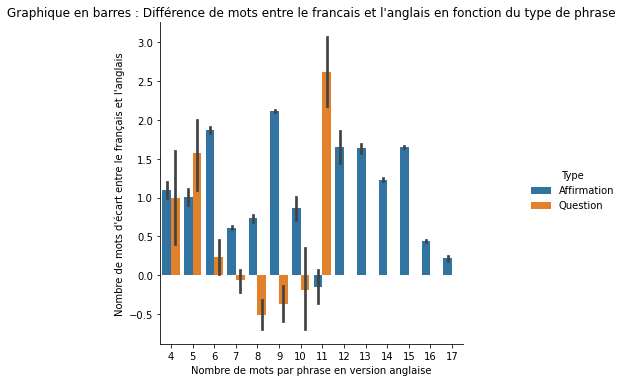

In [10]:
# Ce graphique suivant permet d'affiner l'hypothèse H0

sns.catplot(x="Nb_words_en", y='diff_F-E', hue="Type", kind= "bar", data=nb_words)
plt.title("Graphique en barres : Différence de mots entre le francais et l'anglais en fonction du type de phrase")
plt.xlabel("Nombre de mots par phrase en version anglaise")
plt.ylabel("Nombre de mots d'écart entre le français et l'anglais");

Ce graphique en barre montre que les phrases plus longues en anglais qu'en français (valeur négtive de l'écart) sont très majoritairement des phrases interrogatives. Elles sont constituées de 7 à 10 mots, sur notre échantillon. Pour des petites phrases (moins de 7 mots soit environ 20% des échantillons), il n'est pas possible de prédire une tendance sur les écarts. Cet écart est toutefois en moyenne assez faible (-0.5) au contraire des phrases affirmatives où l'écart est en général plus marqué (+1.5). Pour des phrases de taille moyenne (entre moins de 11 mots soit 70% des échantillons), l'écart de mots est globalement négatif pour les questions, avec une disparité importante (barre noire). Pour des phrases de grande taille (plus de 11 mots soit environ 10% des échantillons), l'écart est fortement positif.

En conclusion, dans la moitié des cas, les phrases interrogatives sont plus longues en anglais, seulement l'écart étant plus prononcé en positif, la moyenne reste très légèrement positive. **L'hypothèse H0 est validée.**


### 4. Occurence des mots et Word Cloud   
   
   

Après l'analyse des mots par phrases, nous allons analyser les mots en tant que tels.

En effet, après avoir analyser l'écart de mots entre les phrases françaises et anglaises, nous allons voir si cela provient d'un écart entre les mots utilisés et si cela a un impact sur le message transmis.


#### Occurence des mots   
   
   

In [15]:
# Transfert des phrases du dataframe en chaines de caractères
text_fr = ""
for word in data.Français:
    text_fr += word
    
text_eng = ""
for word in data.English:
    text_eng += word
    
# Retrait des caractères de ponctuations, remplacés par un espace
text_fr_2 = ''.join(' ' if c in ".,-?" else c for c in text_fr) 
text_eng_2 = ''.join(' ' if c in ".,-?" else c for c in text_eng)

# Création des listes de mots par langue
from nltk.tokenize import word_tokenize
words_fr = word_tokenize(text_fr_2, language = 'french')
words_eng = word_tokenize(text_eng_2, language = 'english')

#print("L'ensemble des phrases en français présentent", len(words_fr), "mots, \
#les phrases en anglais présentent quant à elles", len(words_eng), "mots, ce qui implique une différence \
#dans la construction des phrases entre français et anglais de", len(words_fr) - len(words_eng), "mots.")

L'ensemble des phrases en français présentent 1 673 358 mots, les phrases en anglais présentent quant à elles 1 501 574 mots, ce qui implique une différence dans la construction des phrases entre français et anglais de 171 784 mots de plus en français.
Cela confirme les observations précédentes dans lesquelles les phrases en français sont plus longues qu'en anglais.

La question à présent est de savoir si le vocabulaire utilisé dans ces deux langues est similaire, que ce soit en termes de mots utilisés (mots uniques) ou de thématique.

In [18]:
unique_fr = []
for word in words_fr:
    if word not in unique_fr:
        unique_fr.append(word)

unique_eng = []
for word in words_eng:
    if word not in unique_eng:
        unique_eng.append(word)
        
#print(len(unique_fr), len(unique_eng))

On remarque que seuls 346 mots français et 197 mots anglais ont été utilisés pour construire ces phrases.
Il s'agit là d'une grande disparité dans le nombre de mots utilisés entre ces deux langues.

Nous allons étudier si ces différences impactent le sens et le thème des phrases en nous basant sur l'étude des Word Cloud des 100 mots les plus récurrents de ces deux langues.

#### Word Cloud

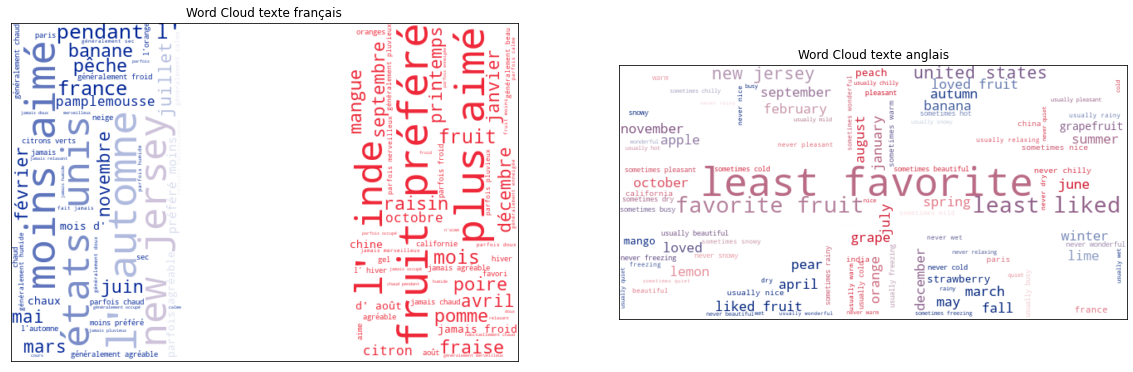

In [28]:
import nltk
from nltk.corpus import stopwords

# Création des listes des mots vides à supprimer
del_words_eng = set(stopwords.words('english'))
del_words_fr = set(stopwords.words('french'))
del_words_eng.update([',', '.', '?', '-'])
del_words_fr.update([',', '.', '?', '-'])

# Création des Word Cloud
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

# Définition des masques
mask_fr = np.array(Image.open("drapeau_france.jpg"))
mask_eng = np.array(Image.open("drapeau_uk.jpg"))

# Définition des calques des Word Cloud : 100 mots maximum du fait du nombre de mots utilisés
wc_fr = WordCloud(background_color = "white", max_words = 100, 
                 stopwords = del_words_fr, mask = mask_fr, 
                 max_font_size = 50, random_state= 42, mode = 'RGBA')
wc_eng = WordCloud(background_color = "white", max_words = 100, 
                 stopwords = del_words_eng, mask = mask_eng, 
                 max_font_size = 50, random_state= 42, mode = 'RGBA')

# Création des couleurs à partir des masques
image_colors_fr = ImageColorGenerator(mask_fr)
image_colors_eng = ImageColorGenerator(mask_eng)

# Génération des Word Cloud
plt.figure(figsize = (20,10))
wc_fr.generate(text_fr)
wc_eng.generate(text_eng)
plt.subplot(121).imshow(wc_fr.recolor(color_func = image_colors_fr), interpolation = "bilinear")
plt.xticks([])
plt.yticks([])
plt.title("Word Cloud texte français")
plt.subplot(122).imshow(wc_eng.recolor(color_func = image_colors_eng), interpolation = "bilinear")
plt.xticks([])
plt.yticks([])
plt.title("Word Cloud texte anglais")
plt.show()


On observe que malgré les différences de nombres de mots utilisés, les thématiques récurrentes restent les mêmes : les fruits, les mois, saisons et temps, les pays et lieux, les préférences sont les thèmes des phrases étudiées.

### 5. Etude sur la nature des mots

Après nous être intéressé aux types de phrases, nous avons étudié les types de mots présents dans le DataFrame. Pour ce faire, nous avons séparé les phrases en mots pour utiliser une méthode de POS tagging pour identifier les différents types : noms, verbes, adjectifs, adverbes...

Nous avons réalisé cette opération en anglais dans un premier temps et en français d'autre part.

Nous avons également retiré les doublons de mots afin de n'obtenir que le nombre de mots uniques par type de mots. Ce nombre de mots uniques associé au nombre total nous permet d'estimer le nombre moyen d'occurences par mots. Plus le nombre d'occurences est élevé, plus les algorithmes que nous construirons auront d'exemples pour affiner leurs prédictions.

#### Etiquettage des mots anglais

In [3]:
#On reindexe le dataframe car il y a des index manquants dû au drop_duplicate
new_index = [np.arange(0,len(data))]
data.set_index(new_index, drop=True, append=False, inplace=True, verify_integrity=False)

In [4]:
#On divise le jeu de données en deux DataFrames : Un pour l'anglais et un pour le français
data_fr = data.drop(labels = 'English', axis = 1)
data_en = data.drop(labels = 'Français', axis = 1)

In [5]:
#On définit une fonction qui découpe une phrase en plusieurs mots et qui étiquette chaque mot en fonction
#de sa  nature
def posTagging(phrase):  
    # On découpe la phrase
    wordsList = word_tokenize(phrase)
    # On trouve la nature de chaque mot grace au module pos_tag de nltk
    tagged = pos_tag(wordsList, tagset='universal')
    # On converti la liste (mot,nature) en mot_nature 
    tagged = list(map(lambda X: '_'.join(X), tagged))
    
    return ' '.join(tagged)

In [6]:
#On applique la fonction à la colonne English du df Anglais et on attribue les phrases étiquettées dans 
#un nouvelle colonne du même df
data_en['Nature'] = data_en['English'].astype(str).swifter.apply(posTagging)

Pandas Apply:   0%|          | 0/129174 [00:00<?, ?it/s]

In [7]:
data_en.head()

,English,Nature
0,"new jersey is sometimes quiet during autumn , ...",new_ADJ jersey_NOUN is_VERB sometimes_ADV quie...
1,the united states is usually chilly during jul...,the_DET united_ADJ states_NOUN is_VERB usually...
2,"california is usually quiet during march , and...",california_NOUN is_VERB usually_ADV quiet_ADJ ...
3,the united states is sometimes mild during jun...,the_DET united_ADJ states_NOUN is_VERB sometim...
4,"your least liked fruit is the grape , but my l...",your_PRON least_ADJ liked_ADJ fruit_NOUN is_VE...


In [8]:
#On isole chaque mot 
rsplit = re.compile(r"\W+")
split1 = []
for i in range(0,data_en.shape[0]):
    split1.append(rsplit.split(str(data_en.Nature[i])))
split1df = pd.DataFrame(split1)
display(split1df.head())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,new_ADJ,jersey_NOUN,is_VERB,sometimes_ADV,quiet_ADJ,during_ADP,autumn_NOUN,_,and_CONJ,it_PRON,is_VERB,snowy_VERB,in_ADP,april_NOUN,_,,None,None
1,the_DET,united_ADJ,states_NOUN,is_VERB,usually_ADV,chilly_ADV,during_ADP,july_NOUN,_,and_CONJ,it_PRON,is_VERB,usually_ADV,freezing_VERB,in_ADP,november_NOUN,_,
2,california_NOUN,is_VERB,usually_ADV,quiet_ADJ,during_ADP,march_NOUN,_,and_CONJ,it_PRON,is_VERB,usually_ADV,hot_ADJ,in_ADP,june_NOUN,_,,None,None
3,the_DET,united_ADJ,states_NOUN,is_VERB,sometimes_ADV,mild_ADJ,during_ADP,june_NOUN,_,and_CONJ,it_PRON,is_VERB,cold_VERB,in_ADP,september_NOUN,_,,None
4,your_PRON,least_ADJ,liked_ADJ,fruit_NOUN,is_VERB,the_DET,grape_NOUN,_,but_CONJ,my_PRON,least_ADJ,liked_ADJ,is_VERB,the_DET,apple_NOUN,_,,None


In [9]:
#On fait en sorte de transposer tous les mots dans un dataframe d'une colonne seulement
all_values = []
for column in split1df:
    this_column_values = split1df[column].tolist()
    all_values += this_column_values

one_column_df = pd.DataFrame(all_values)
one_column_df.head()

,0
0,new_ADJ
1,the_DET
2,california_NOUN
3,the_DET
4,your_PRON


In [10]:
#On sépare chaque mot de sa nature afin qu'ils soient chacun dans une colonne du dataframe
one_column_df["mot"], one_column_df["Nature"] = one_column_df[0].str.split("_", 1).str
#On enlève ensuite les cellules vides du df
one_column_df.Nature.replace('', np.nan, inplace=True)
one_column_df = one_column_df.dropna()
display(one_column_df.head())
display(one_column_df.shape)
#Nous avons dans un premier temps un df contenant tous les mots utilisés ainsi que leur classe

,0,mot,Nature
0,new_ADJ,new,ADJ
1,the_DET,the,DET
2,california_NOUN,california,NOUN
3,the_DET,the,DET
4,your_PRON,your,PRON


(1501574, 3)

In [11]:
#Nous voulons maintenant avoir un dataframe ou nous stockerons uniquement la première occurence de chaque mot
#Nous supprimons pour ça les doublons en gardant la première occurence en n'oubliant pas de réindexer le Df
unique_en_n = one_column_df
unique_en_n = unique_en_n.drop_duplicates()
unique_en_n = unique_en_n.reset_index(drop = True)
unique_en_n.shape

(253, 3)

#### Etiquettage des mots français

Nous n'avons malheureusement pas pu étiquetter la totalité des mots des phrases en français car le modèle servant à identifier la nature des mots en français étant moins optimisé pour une grande quantité de données, l'application de celui ci sur notre jeu de données prenait beaucoup trop de temps. Nous nous sommes donc uniquement interessés aux nombre de mots uniques et à leurs natures en les étiquettant mot par mot après avoir éliminé les doublons. Le modèle étant certes moins efficace pour étiqueter un mot isolé, le résultat nous permettra tout de même d'avoir un apperçu de la répartition des natures de mots dans les phrases en français.

In [14]:
#Nous appliquons les mêmes opérations que pour l'anglais afin d'obtenir un dataframe d'une colonne 
split2 = []
for i in range(0,data_fr.shape[0]):
    split2.append(rsplit.split(str(data_fr.Français[i])))
split2df = pd.DataFrame(split2)

all_values = []
for column in split2df:
    this_column_values = split2df[column].tolist()
    all_values += this_column_values

one_column_df_fr = pd.DataFrame(all_values)
one_column_df_fr.head()

#Comme pour l'anglais, nous supprimons les doublons et les cases vides afin d'avoir un df de mots uniques
#Puis nous réindexons

unique_fr_n = one_column_df_fr
unique_fr_n.replace('', np.nan, inplace=True)
unique_fr_n = unique_fr_n.dropna()
unique_fr_n = unique_fr_n.drop_duplicates()
unique_fr_n = unique_fr_n.reset_index(drop = True)

In [17]:
# Nous voulons maintenant étiquetter chaque mot avec sa nature
#Nous utilisons pour cela Stanford POSTagger et son modèle entrainé sur du français french-ud.tagger

#Nous commencons par préciser les chemins d'accès des fichiers nécessaires au bon fonctionnement du Tagger
jar = r'.\stanford-postagger-full-2020-11-17\stanford-postagger-4.2.0.jar'
model = r'.\stanford-postagger-full-2020-11-17\models\french-ud.tagger'
import os
java_path = r'C:\Program Files\Java\jdk-16.0.2\bin\java.exe'
os.environ['JAVAHOME'] = java_path

#On instancie le tagger avec les fichiers spécifiés plus haut
pos_tagger = StanfordPOSTagger(model, jar, encoding='utf8' )

#Nous créons la même fonction que pour l'anglais afin d'étiquetter les mots
def posTaggingfr(phrase):  

    wordsList = word_tokenize(phrase)
    
    tagged = pos_tagger.tag(wordsList)
   
    tagged = list(map(lambda X: '_'.join(X), tagged))
    
    return ' '.join(tagged)


In [18]:
#On applique la fonction à tous les mots du datframe obtenu précédemment
unique_fr_n['ettiquetage'] = unique_fr_n[0].astype(str).swifter.apply(posTaggingfr)

Pandas Apply:   0%|          | 0/331 [00:00<?, ?it/s]

In [20]:
#On sépare chaque mot de sa nature afin qu'ils soient chacun dans une colonne du dataframe
unique_fr2 = unique_fr_n
unique_fr2["Mot"],unique_fr2["Nature"] = unique_fr2['ettiquetage'].str.split("_", 1).str
display(unique_fr2.head())

,0,ettiquetage,Mot,Nature
0,new,new_ADJ,new,ADJ
1,les,les_DET,les,DET
2,california,california_SYM,california,SYM
3,votre,votre_DET,votre,DET
4,son,son_DET,son,DET


In [21]:
#Afin de visualiser les données de manière claire, nous changeons les étiquettages des mots afin qu'ils soient 
#reconnaissables
one_column_df['Nature'] = one_column_df["Nature"].replace(['ADJ', 'DET', 'NOUN','PRON', 'ADV', 'VERB', 'ADP', 'PRT', 'CONJ'],
                            ['Adjectif', 'Déterminant', 'Nom','Pronom', 'Adverbe', 'Verbe', 'Adposition', 'Adposition', 'Conjonction'])

unique_en_n['Nature'] = unique_en_n["Nature"].replace(['ADJ', 'DET', 'NOUN','PRON', 'ADV', 'VERB', 'ADP', 'PRT', 'CONJ'],
                            ['Adjectif', 'Déterminant', 'Nom','Pronom', 'Adverbe', 'Verbe', 'Adposition', 'Adposition', 'Conjonction'])

unique_fr2['Nature'] = unique_fr2["Nature"].replace(['ADJ', 'DET', 'SYM', 'NOUN','PRON', 'X', 'ADV', 'VERB', 'SCONJ', 'AUX', 'ADP', 'PROPN', 'CCONJ'],
                            ['Adjectif', 'Déterminant', 'Nom','Nom','Pronom', np.nan, 'Adverbe', 'Verbe', 'Conjonction', 'Verbe', 'Adposition', 'Nom', 'Conjonction'])


In [23]:
#On fusionne les colonnes nature des df contenant les mots uniques des deux langues afin de visualiser 
#les occurences de chaque nature, pour chaque langue sur un même diagramme

unique_tot =pd.DataFrame(pd.concat([unique_fr2.Nature, unique_en_n.Nature], axis = 0))
unique_tot = unique_tot.reset_index(drop = True)

#On ajoute une colonne Langue afin de préciser de quel langue provient chaque occurence de chaque nature

unique_tot['Langue'] = 0
unique_tot.iloc[0:unique_fr2.shape[0],1] = 'Français'
unique_tot.iloc[unique_fr2.shape[0]:,1] = 'Anglais'


#### Visualisation

Nous commencons tout d'abord par visualiser le nombre total de mots anglais en fonction de leur nature respective afin d'avoir un idée de la distribution de chaque nature en prenant en compte tous les mots anglais.

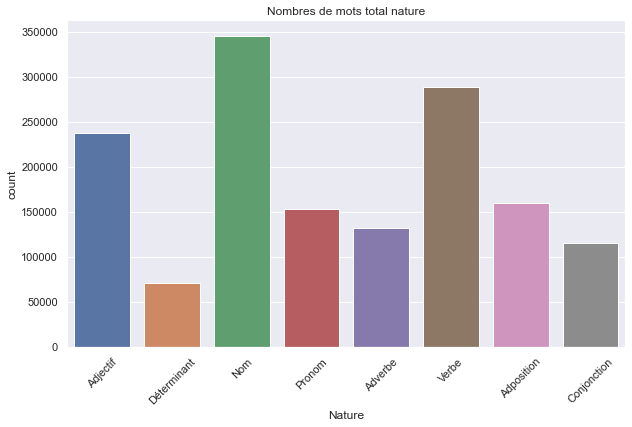

In [29]:
#On regarde dans un premier temps le nombre de mots pas catégorie au total
sns.set_theme()
plt.figure(figsize=(10, 6));
sns.countplot(x = one_column_df.Nature)
plt.title('Nombres de mots total nature');
plt.xticks(rotation=45);

Nous pouvons constater que les natures les plus utilisées sont les Noms et les Verbes ce qui semble logique. Mais il est plus intéressant d'observer la comparaison entre les distributions de natures des mots uniques pour chaque langue.

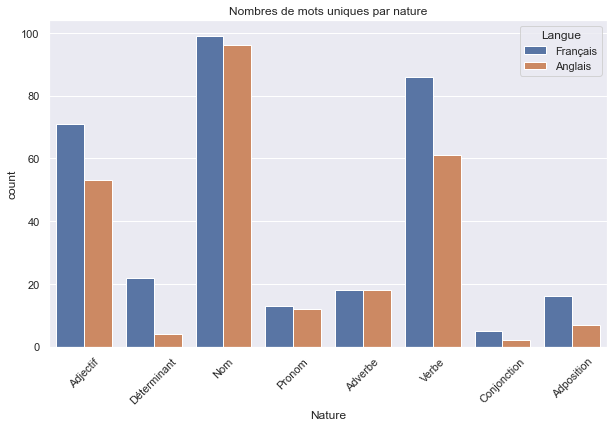

In [30]:
plt.figure(figsize=(10, 6));
sns.countplot(x = unique_tot['Nature'], hue = unique_tot.Langue)
plt.xticks(rotation=45)
plt.title('Nombres de mots uniques par nature');

Nous pouvons constater que les noms et les verbes sont les types majoritaires en français et en anglais. Il est également intéressant de souligner que pour la quasi totalité des natures, il y a plus de mots français qu'anglais. Cela veut donc forcément dire qu'il y a des mots anglais qui ont plusieurs correspondances en français. Cela pourrait poser problème pour l'apprentissage du modèle. Il faudra donc faire attention aux mots ayant plusieurs traductions françaises.

Nous constatons également que le nombre de mots uniques est assez restreint quel que soit le type. Pour comparaison, le dictionnaire Oxford comprend 171 476 mots actuellement utilisés (même si en moyenne les anglophones n'utilisent que 20 000 à 30 000 mots). L'algorithme devra donc fortement extrapoler à partir des mots fournis.

Comme le nombre de mots uniques est bien plus faible que le nombre total de mots, l'algorithmes aura toutefois beaucoup d'éléments pour affiner ses prédictions.